In [57]:
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.recurrent import LSTM
from keras.models import Sequential

#helper libraries
import time 
import lstm

In [162]:
#Step 1 Load Data
X_train, y_train, X_test, y_test = lstm.load_data('sp500.csv', 50, True)

In [163]:
#Step 2 Build Model
model = Sequential()

model.add(LSTM(
    input_dim=1,
    output_dim=50,
    return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(
    100,
    return_sequences=False))
model.add(Dropout(0.2))

model.add(Dense(
    output_dim=1))
model.add(Activation('linear'))

start = time.time()
model.compile(loss='mse', optimizer='rmsprop')
print ('compilation time : ', time.time() - start)

compilation time :  0.031003236770629883


In [164]:
print (X_train.shape)
print (X_test.shape)
print (y_train.shape)
print (y_test.shape)

(3709, 50, 1)
(412, 50, 1)
(3709,)
(412,)


In [165]:

#Step 3 Train the model
model.fit(
    X_train,
    y_train,
    batch_size=512,
    nb_epoch=1,
    validation_split=0.05)

Train on 3523 samples, validate on 186 samples
Epoch 1/1
3523/3523 [==============================] - 19s 5ms/step - loss: 0.0020 - val_loss: 9.6835e-04


yo


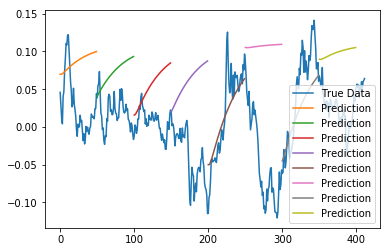

In [166]:
#Step 4 - Plot the predictions!
predictions = lstm.predict_sequences_multiple(model, X_test, 50, 50)
lstm.plot_results_multiple(predictions, y_test, 50)

In [ ]:
# %load lstm.py
import time
import warnings
import numpy as np
from numpy import newaxis
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.recurrent import LSTM
from keras.models import Sequential
import matplotlib.pyplot as plt


warnings.filterwarnings("ignore")

def plot_results_multiple(predicted_data, true_data, prediction_len):
    fig = plt.figure(facecolor='white')
    ax = fig.add_subplot(111)
    ax.plot(true_data, label='True Data')
    print ('yo')
    #Pad the list of predictions to shift it in the graph to it's correct start
    for i, data in enumerate(predicted_data):
        padding = [None for p in range(i * prediction_len)]
        plt.plot(padding + data, label='Prediction')
        plt.legend()
    plt.show()

def load_data(filename, seq_len, normalise_window):
    f = open(filename, 'r').read()
    data = f.split('\n')

    sequence_length = seq_len + 1
    result = []
    for index in range(len(data) - sequence_length):
        result.append(data[index: index + sequence_length])
    
    if normalise_window:
        result = normalise_windows(result)

    result = np.array(result)

    row = round(0.9 * result.shape[0])
    train = result[:int(row), :]
    np.random.shuffle(train)
    x_train = train[:, :-1]
    y_train = train[:, -1]
    x_test = result[int(row):, :-1]
    y_test = result[int(row):, -1]

    x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
    x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))  

    return [x_train, y_train, x_test, y_test]

def normalise_windows(window_data):
    normalised_data = []
    for window in window_data:
        normalised_window = [((float(p) / float(window[0])) - 1) for p in window]
        normalised_data.append(normalised_window)
    return normalised_data

def build_model(layers):
    model = Sequential()

    model.add(LSTM(
        input_dim=layers[0],
        output_dim=layers[1],
        return_sequences=True))
    model.add(Dropout(0.2))

    model.add(LSTM(
        layers[2],
        return_sequences=False))
    model.add(Dropout(0.2))

    model.add(Dense(
        output_dim=layers[3]))
    model.add(Activation("linear"))

    start = time.time()
    model.compile(loss="mse", optimizer="rmsprop")
    print ("Compilation Time : ", time.time() - start)
    return model

def predict_point_by_point(model, data):
    #Predict each timestep given the last sequence of true data, in effect only predicting 1 step ahead each time
    predicted = model.predict(data)
    predicted = np.reshape(predicted, (predicted.size,))
    return predicted


def predict_sequence_full(model, data, window_size):
    #Shift the window by 1 new prediction each time, re-run predictions on new window
    curr_frame = data[0]
    predicted = []
    for i in range(len(data)):
        predicted.append(model.predict(curr_frame[newaxis,:,:])[0,0])
        curr_frame = curr_frame[1:]
        curr_frame = np.insert(curr_frame, [window_size-1], predicted[-1], axis=0)
    return predicted

def predict_sequences_multiple(model, data, window_size, prediction_len):
    #Predict sequence of 50 steps before shifting prediction run forward by 50 steps
    prediction_seqs = []
    for i in range(len(data)//prediction_len):
        curr_frame = data[i*prediction_len]
        predicted = []
        for j in range(prediction_len):
            predicted.append(model.predict(curr_frame[newaxis,:,:])[0,0])
            curr_frame = curr_frame[1:]
            curr_frame = np.insert(curr_frame, [window_size-1], predicted[-1], axis=0)
        prediction_seqs.append(predicted)
    return prediction_seqs

### sliding window and train test split 

In [15]:
def normalise_windows(window_data):
    normalised_data = []
    for window in window_data:
        normalised_window = [((float(p) / float(window[0])) - 1) for p in window]
        normalised_data.append(normalised_window)
    return normalised_data

In [45]:
# lstm.load_data('sp500.csv', 50, True)

# def load_data(filename, seq_len, normalise_window):

filename = 'sp500.csv'
seq_len = 50
normalise_window = True 

f = open(filename, 'r').read()
data = f.split('\n')

In [46]:
len(data)

4172

In [19]:
import numpy as np

sequence_length = seq_len + 1
result = []

# the sequences are generated by moving the 51 day window 1 day forward gradually until there's no 51 day range left at the end
for index in range(len(data) - sequence_length):
    result.append(data[index: index + sequence_length])

if normalise_window:
    result = normalise_windows(result)

result = np.array(result)

In [48]:
print (result.shape)

print (type(result))
result[0]

(4121, 51)
<class 'numpy.ndarray'>


array([ 0.        ,  0.00278269, -0.00461635,  0.01058087,  0.01052695,
        0.01226345,  0.01280814,  0.01233896,  0.00719411,  0.00750148,
       -0.00428739, -0.00709707,  0.00244833,  0.00968563,  0.00349459,
        0.0095562 ,  0.00659551,  0.00169871,  0.00611013, -0.00093296,
       -0.00283127,  0.00179581,  0.00973414,  0.01684202,  0.0197434 ,
        0.01859471,  0.00582429, -0.00498843, -0.00125659,  0.00964791,
       -0.01143838, -0.02081665, -0.01277042, -0.0060994 ,  0.00432512,
        0.00569487,  0.00949149,  0.01362247,  0.01137901,  0.0131155 ,
        0.00491292,  0.00816486,  0.01296449,  0.01599529,  0.01584974,
        0.01447992,  0.01637823,  0.00724263,  0.01289977,  0.01150843,
        0.01304539])

In [23]:
# 90% of the sliced 50 day windows as training data 

row = round(0.9 * result.shape[0])

train = result[:int(row), :]
# This function only shuffles the array along the first axis of a multi-dimensional array. 
# The order of sub-arrays is changed but their contents remains the same 
np.random.shuffle(train)

# split each 51day window to 50days feature data and 1 day dependent values 
# reshape the feature space as Keras requires a specific input data structure 

x_train = train[:, :-1]
y_train = train[:, -1]
x_test = result[int(row):, :-1]
y_test = result[int(row):, -1]

x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1)) 

In [34]:
print (train.shape)

train[0]

# train[1]

(3709, 51)


array([ 0.        ,  0.00278269, -0.00461635,  0.01058087,  0.01052695,
        0.01226345,  0.01280814,  0.01233896,  0.00719411,  0.00750148,
       -0.00428739, -0.00709707,  0.00244833,  0.00968563,  0.00349459,
        0.0095562 ,  0.00659551,  0.00169871,  0.00611013, -0.00093296,
       -0.00283127,  0.00179581,  0.00973414,  0.01684202,  0.0197434 ,
        0.01859471,  0.00582429, -0.00498843, -0.00125659,  0.00964791,
       -0.01143838, -0.02081665, -0.01277042, -0.0060994 ,  0.00432512,
        0.00569487,  0.00949149,  0.01362247,  0.01137901,  0.0131155 ,
        0.00491292,  0.00816486,  0.01296449,  0.01599529,  0.01584974,
        0.01447992,  0.01637823,  0.00724263,  0.01289977,  0.01150843,
        0.01304539])

In [49]:
x_train = train[:, :-1]

print (x_train.shape)
print (x_train[0].shape)

x_train[0]

(3709, 50)
(50,)


array([ 0.        ,  0.00278269, -0.00461635,  0.01058087,  0.01052695,
        0.01226345,  0.01280814,  0.01233896,  0.00719411,  0.00750148,
       -0.00428739, -0.00709707,  0.00244833,  0.00968563,  0.00349459,
        0.0095562 ,  0.00659551,  0.00169871,  0.00611013, -0.00093296,
       -0.00283127,  0.00179581,  0.00973414,  0.01684202,  0.0197434 ,
        0.01859471,  0.00582429, -0.00498843, -0.00125659,  0.00964791,
       -0.01143838, -0.02081665, -0.01277042, -0.0060994 ,  0.00432512,
        0.00569487,  0.00949149,  0.01362247,  0.01137901,  0.0131155 ,
        0.00491292,  0.00816486,  0.01296449,  0.01599529,  0.01584974,
        0.01447992,  0.01637823,  0.00724263,  0.01289977,  0.01150843])

In [65]:
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

print (x_train.shape) 

print (x_train[0].shape)

# x_train[0]

(3709, 50, 1)
(50, 1)


In [70]:
print (X_test.shape)
X_test[0]

(412, 50, 1)


array([[  0.00000000e+00],
       [  5.14346191e-06],
       [  1.11707103e-02],
       [  9.58806659e-03],
       [ -5.68301569e-03],
       [  1.16793997e-02],
       [ -9.22332834e-03],
       [ -2.05687242e-02],
       [ -3.66979296e-02],
       [ -3.51770059e-02],
       [ -4.29923760e-02],
       [ -4.28536310e-02],
       [ -3.05216544e-02],
       [ -2.16580462e-02],
       [ -2.50750448e-03],
       [ -9.78853160e-03],
       [  2.39441357e-03],
       [  9.46475196e-03],
       [  7.94897168e-03],
       [  1.99829481e-02],
       [  1.85699091e-02],
       [  2.49157259e-02],
       [  3.69394159e-02],
       [  3.68161013e-02],
       [  3.38820759e-02],
       [  3.97757176e-02],
       [  4.37014046e-02],
       [  4.40662682e-02],
       [  4.73239479e-02],
       [  4.80536124e-02],
       [  4.73188044e-02],
       [  4.78737207e-02],
       [  4.81254935e-02],
       [  4.88962420e-02],
       [  5.42812580e-02],
       [  5.26986143e-02],
       [  5.47693736e-02],
 

### Predict sequence of 50 steps before shifting prediction run forward by 50 steps

In [168]:
# def predict_sequences_multiple(model, data, window_size, prediction_len):
model
data = X_test
window_size = 50
prediction_len = 50

# the model is trained on data of the following dimension (3709, 50, 1)
# within each 50 day window in X_test, which has the dimension of (412, 50, 1),
# predict the value using the original 50 data points in the testing 50 day window at first
# then update the window by removing the firs point at ataching the just predicted value to the end of the window, keeping the same timespan of 50 days
# repeat until all the points in the current window are predicted

# the move to the next 50 day window that does not overlap with the one just predicted 

from numpy import newaxis

# Predict sequence of 50 steps before shifting prediction run forward by 50 steps

# model.predict returns Numpy array(s) of predictions.
# model.predict requires input as Numpy array or list of Numpy arrays if the model has multiple outputs  

prediction_seqs = []

for i in range(len(data) // prediction_len):
    curr_frame = data[i* prediction_len]
    
    predicted = []
    
    for j in range(prediction_len):
        predicted.append(model.predict(curr_frame[newaxis, :, :])[0, 0])
        curr_frame = curr_frame[1:]
        
        #  Insert values along the given axis before the given indices.
        curr_frame = np.insert(curr_frame, [window_size - 1], predicted[-1], axis = 0)
    prediction_seqs.append(predicted)
    
        
print (len(prediction_seqs))

8


In [134]:
len(prediction_seqs[0])

print (X_test.shape)
print (X_test[411].shape)

(412, 50, 1)
(50, 1)


In [150]:
curr_frame = X_test[0]
print (curr_frame.shape)
print (curr_frame[newaxis,:,:].shape)
print (model.predict(curr_frame[newaxis, :, :]))

predicted = []
predicted.append(model.predict(curr_frame[newaxis, :, :])[0, 0])

curr_frame = curr_frame[1:]
curr_frame = np.insert(curr_frame, [window_size - 1], predicted[-1], axis = 0)

(50, 1)
(1, 50, 1)
[[ 0.06365193]]


In [173]:
# curr_frame

hey


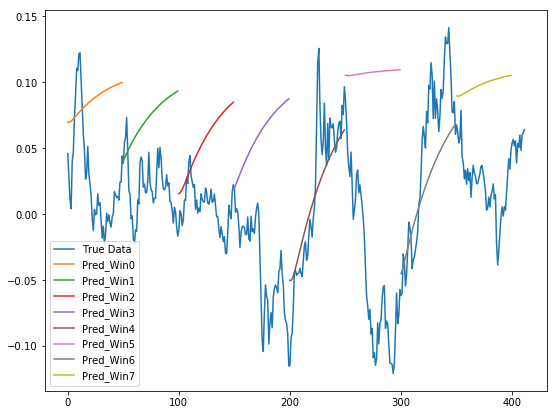

In [180]:
# def plot_results_multiple(predicted_data, true_data, prediction_len):

predicted_data = prediction_seqs
prediction_len = 50 
true_data = y_test 

fig = plt.figure(figsize = (9, 7))
ax = fig.add_subplot(1, 1, 1)
ax.plot(true_data, label='True Data')

print ('hey')
# Pad the list of predictions to shift it in the graph to it's correct start
for i, data in enumerate(predicted_data):
    padding = [None for p in range(i * prediction_len)]
    plt.plot(padding + data, label = 'Pred_Win' + str(i))
    plt.legend()
plt.show()


### Predict 1 step ahead each time

In [170]:
# def predict_point_by_point(model, data):

# Predict each timestep given the last sequence of true data, in effect only predicting 1 step ahead each time
print (X_test.shape) 

# list of Numpy arrays as inputs, multiple outputs prediciton
# The first dimension is the number of different sequences. The second is the length of the sequence (how many measures along time). 
# And the last is the number of variables/features at each time.
predicted = model.predict(X_test)
print (predicted.shape)

# predicted = np.reshape(predicted, (predicted.size,))



(412, 50, 1)
(412, 1)


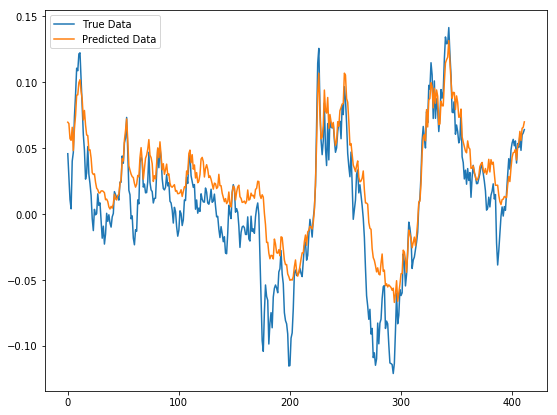

In [182]:
fig = plt.figure(figsize = (9, 7))
plt.plot(true_data, label='True Data')
plt.plot(predicted, label='Predicted Data')
plt.legend()